# Final Code with SMOTE

### Configuration and Imports 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
import seaborn as sns
import time
import warnings
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

### Data Loading

In [2]:
# Load data
LargeTrain = pd.read_csv('train.csv')
SmallTest = pd.read_csv('Original_ObesityDataSet.csv')

In [3]:
LargeTrain.shape

(20758, 18)

In [4]:
SmallTest.shape

(2111, 17)

### Data Preprocessing


In [5]:
# Drop unnecessary columns
LargeTrain = LargeTrain.drop(columns='id')

# Extract features and target
y_train = LargeTrain['NObeyesdad']
X_train = LargeTrain.drop(columns='NObeyesdad')
y_test = SmallTest['NObeyesdad']  # y_validation
X_test = SmallTest.drop(columns='NObeyesdad')  # X_validation

# Define numerical and categorical features
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'CALC', 'SCC', 'MTRANS']


### Custom Transformers

In [6]:
# Custom Transformers
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features):
        self.numerical_features = numerical_features
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.numerical_features])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numerical_features] = self.scaler.transform(X[self.numerical_features])
        return X_copy

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    def fit(self, X, y=None):
        X_copy = pd.DataFrame(X, columns=numerical_features + categorical_features)
        self.one_hot_encoder.fit(X_copy[['MTRANS']])
        return self

    def transform(self, X):
        X_copy = pd.DataFrame(X, columns=numerical_features + categorical_features)

        # Map categorical features to numerical values
        X_copy['family_history_with_overweight'] = X_copy['family_history_with_overweight'].map({'yes': 1, 'no': 0})
        X_copy['FAVC'] = X_copy['FAVC'].map({'yes': 1, 'no': 0})
        X_copy['SMOKE'] = X_copy['SMOKE'].map({'yes': 1, 'no': 0})
        X_copy['SCC'] = X_copy['SCC'].map({'yes': 1, 'no': 0})
        X_copy['Gender'] = X_copy['Gender'].map({'Male': 1, 'Female': 0})

        custom_mapping = {'no': 1, 'Sometimes': 2, 'Frequently': 3, 'Always': 4}
        X_copy['CAEC'] = X_copy['CAEC'].map(custom_mapping)
        X_copy['CALC'] = X_copy['CALC'].map(custom_mapping)

        means_of_trns_encoded = pd.DataFrame(
            self.one_hot_encoder.transform(X_copy[['MTRANS']]),
            columns=self.one_hot_encoder.get_feature_names_out(['MTRANS'])
        )
        
        transformed_df = X_copy.join(means_of_trns_encoded)
        transformed_df = transformed_df.drop(["MTRANS"], axis=1)
        
        return transformed_df

### Handling Missing Values

In [7]:
# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),  # use median if preferred
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_features)
    ])


### Encoding Target Variable

In [8]:
# Encode target variables
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### Model Pipelines

In [9]:
# Define the pipelines with preprocessing, SMOTE, and classifier
base_pipelines = {
    'Decision Tree': imPipeline(steps=[
        ('preprocessor', preprocessor),
        ('custom_transformer', CustomTransformer()),
        ('custom_scaler', CustomScaler(numerical_features)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', DecisionTreeClassifier(max_depth=10, random_state=42))
    ]),

    'Logistic Regression': imPipeline(steps=[
        ('preprocessor', preprocessor),
        ('custom_transformer', CustomTransformer()),
        ('custom_scaler', CustomScaler(numerical_features)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42))
    ]),

    'SVM': imPipeline(steps=[
        ('preprocessor', preprocessor),
        ('custom_transformer', CustomTransformer()),
        ('custom_scaler', CustomScaler(numerical_features)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', SVC(probability=True, random_state=42))
    ]),

    'Random Forest': imPipeline(steps=[
        ('preprocessor', preprocessor),
        ('custom_transformer', CustomTransformer()),
        ('custom_scaler', CustomScaler(numerical_features)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42))
    ]),

    'XGBoost': imPipeline(steps=[
        ('preprocessor', preprocessor),
        ('custom_transformer', CustomTransformer()),
        ('custom_scaler', CustomScaler(numerical_features)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(n_estimators=200, max_depth=10, random_state=42))
    ])
}

### Choosing k value

Number of Folds: 3, CV Mean Accuracy: 0.8712 Decision Tree
Number of Folds: 3, CV Mean Accuracy: 0.8598 Logistic Regression
Number of Folds: 3, CV Mean Accuracy: 0.8759 SVM
Number of Folds: 3, CV Mean Accuracy: 0.8964 Random Forest
Number of Folds: 3, CV Mean Accuracy: 0.8983 XGBoost
Number of Folds: 5, CV Mean Accuracy: 0.8731 Decision Tree
Number of Folds: 5, CV Mean Accuracy: 0.8596 Logistic Regression
Number of Folds: 5, CV Mean Accuracy: 0.8792 SVM
Number of Folds: 5, CV Mean Accuracy: 0.8973 Random Forest
Number of Folds: 5, CV Mean Accuracy: 0.8991 XGBoost
Number of Folds: 10, CV Mean Accuracy: 0.8768 Decision Tree
Number of Folds: 10, CV Mean Accuracy: 0.8611 Logistic Regression
Number of Folds: 10, CV Mean Accuracy: 0.8796 SVM
Number of Folds: 10, CV Mean Accuracy: 0.8982 Random Forest
Number of Folds: 10, CV Mean Accuracy: 0.8996 XGBoost


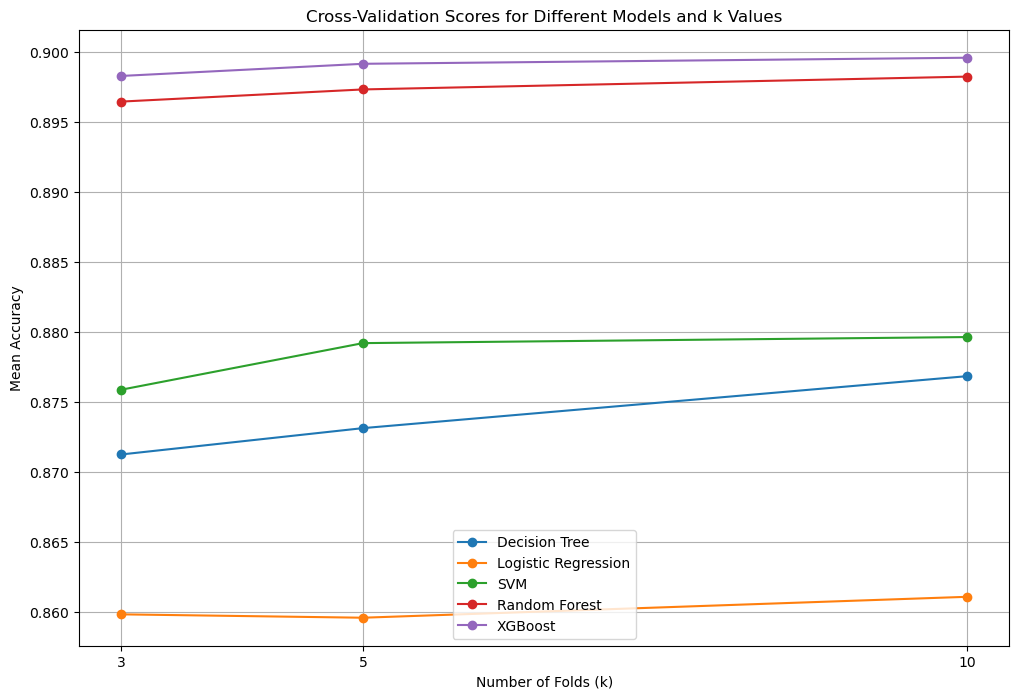

In [10]:
# Perform cross-validation for different values of k
cv_scores = {}
kf_values = [3, 5, 10]  # Example values of k
for k in kf_values:
    cv_scores[k] = {}
    for model_name, pipeline in base_pipelines.items():
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=kf, scoring='accuracy')
        cv_scores[k][model_name] = np.mean(scores)
        print(f'Number of Folds: {k}, CV Mean Accuracy: {np.mean(scores):.4f}', model_name)

# Plot the results
plt.figure(figsize=(12, 8))
for model_name in base_pipelines.keys():
    scores = [cv_scores[k][model_name] for k in kf_values]
    plt.plot(kf_values, scores, marker='o', label=model_name)

plt.title('Cross-Validation Scores for Different Models and k Values')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(kf_values)
plt.show()


In [11]:

dt_pipeline = base_pipelines['Decision Tree']
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores_dt = cross_val_score(dt_pipeline, X_train, y_train, cv=kf, scoring='accuracy')

# Print cross-validation scores
print("Decision Tree Cross-Validation Scores:")
print(cv_scores_dt)
print("Mean Accuracy: {:.4f}".format(cv_scores_dt.mean()))

Decision Tree Cross-Validation Scores:
[0.87813102 0.88102119 0.86753372 0.8805395  0.87475915 0.88150289
 0.87909441 0.87957611 0.87662651 0.86939759]
Mean Accuracy: 0.8768


In [12]:
logreg_pipeline = base_pipelines['Logistic Regression']

cv_scores_logreg = cross_val_score(logreg_pipeline, X_train, y_train, cv=kf, scoring='accuracy')

# Print cross-validation scores
print("Logistic Regression Cross-Validation Scores:")
print(cv_scores_logreg)
print("Mean Accuracy: {:.4f}".format(cv_scores_logreg.mean()))


Logistic Regression Cross-Validation Scores:
[0.85356455 0.87186898 0.84971098 0.86175337 0.86464355 0.87235067
 0.85356455 0.86512524 0.86506024 0.85301205]
Mean Accuracy: 0.8611


In [89]:
#Check LR model on Test data
# Fit the pipeline on the training data
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE']),
                                                 ('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'CALC', 'SCC',
                                                   'MTRANS'])])),
                ('custom_transformer', CustomTransformer()),
                ('custom_scaler',
                 CustomScaler(numerical_features=['Age', 'Height', 'Weight',
                                                  'FCVC', 'NCP', 'CH2O', 'FAF',
                                                  'TUE'])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

In [90]:
y_test_pred_lg = logreg_pipeline.predict(X_test)
accuracy_score(y_test, y_test_pred_lg)

0.9133112269066793

In [13]:
svm_pipeline = base_pipelines['SVM']

cv_scores_svm = cross_val_score(svm_pipeline, X_train, y_train, cv=kf, scoring='accuracy')

# Print cross-validation scores
print("SVM Cross-Validation Scores:")
print(cv_scores_svm)
print("Mean Accuracy: {:.4f}".format(cv_scores_svm.mean()))


SVM Cross-Validation Scores:
[0.87475915 0.88776493 0.87716763 0.87331407 0.88728324 0.8916185
 0.87861272 0.87764933 0.87662651 0.8713253 ]
Mean Accuracy: 0.8796


In [14]:
svm_pipeline.fit(X_train, y_train)
y_test_pred_svm = svm_pipeline.predict(X_test)
accuracy_score(y_test, y_test_pred_svm)

0.9289436286120322

In [87]:
rf_pipeline = base_pipelines['Random Forest']
cv_scores_rf = cross_val_score(rf_pipeline, X_train, y_train, cv=kf, scoring='accuracy')

# Print cross-validation scores
print("Random Forest Cross-Validation Scores:")
print(cv_scores_rf)
print("Mean Accuracy: {:.4f}".format(cv_scores_rf.mean()))


Random Forest Cross-Validation Scores:
[0.90125241 0.90606936 0.89354528 0.89739884 0.90077071 0.90125241
 0.89836224 0.89354528 0.89493976 0.89493976]
Mean Accuracy: 0.8982


In [93]:
rf_pipeline.fit(X_train, y_train)
y_test_pred_rf = rf_pipeline.predict(X_test)
accuracy_score(y_test, y_test_pred_rf)

0.9422074846044529

In [15]:
# Cross-validation for XGBoost
xgb_pipeline= base_pipelines['XGBoost']

cv_scores_xgb = cross_val_score(xgb_pipeline, X_train, y_train_encoded, cv=kf, scoring='accuracy')
print("XGBoost Cross-Validation Scores:")
print(cv_scores_xgb)
print("Mean Accuracy: {:.4f}".format(cv_scores_xgb.mean()))

# Test predictions with XGBoost
xgb_pipeline.fit(X_train, y_train_encoded)
y_test_pred_xgb = xgb_pipeline.predict(X_test)
print("XGBoost Accuracy on Test set:", accuracy_score(y_test_encoded, y_test_pred_xgb))

XGBoost Cross-Validation Scores:
[0.9017341  0.90703276 0.89691715 0.89402697 0.89932563 0.90655106
 0.89884393 0.89402697 0.89975904 0.8973494 ]
Mean Accuracy: 0.8996
XGBoost Accuracy on Test set: 0.9502605400284225


In [17]:

# Define parameter grids for GridSearchCV
param_grids = {
    'Decision Tree': {
        'classifier__max_depth': [10, 20, 30],
        'classifier__min_samples_split': [2, 10, 20],
        'classifier__min_samples_leaf': [1, 5, 10]
    },
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100, 1000],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['linear', 'rbf', 'poly']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30],
        'classifier__min_samples_split': [2, 10, 20]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_estimators = {}

# Perform GridSearchCV for each pipeline
for name, pipeline in base_pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=kf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train_encoded)
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {name}: {grid_search.best_score_:.4f}")

# Evaluate the best models on the test set
for name, model in best_estimators.items():
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_test_pred)
    print(f"{name} Accuracy on Test set: {accuracy:.4f}")


Best parameters for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}
Best cross-validation accuracy for Decision Tree: 0.8759
Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Best cross-validation accuracy for Logistic Regression: 0.8631
Best parameters for SVM: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best cross-validation accuracy for SVM: 0.8794
Best parameters for Random Forest: {'classifier__max_depth': 30, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best cross-validation accuracy for Random Forest: 0.8976
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Best cross-validation accuracy for XGBoost: 0.9063
Decision Tree Accuracy on Test set: 0.9223
Logistic Regression Accuracy on Test set: 0.9166
SVM Accuracy on Test set: 0.9289


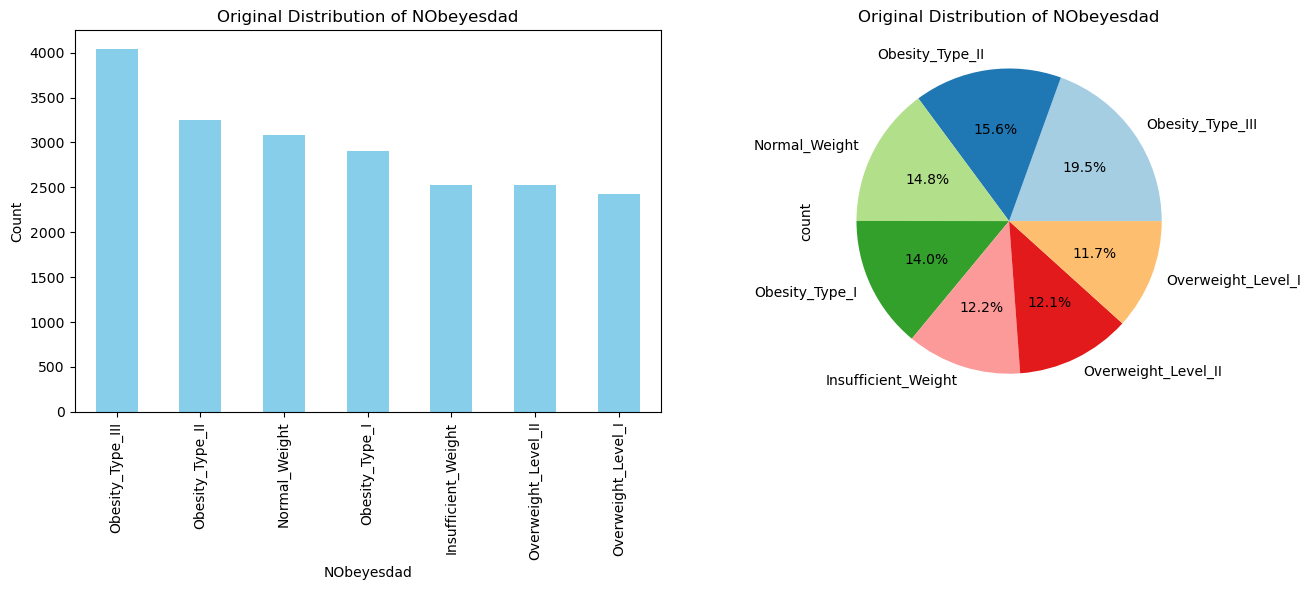

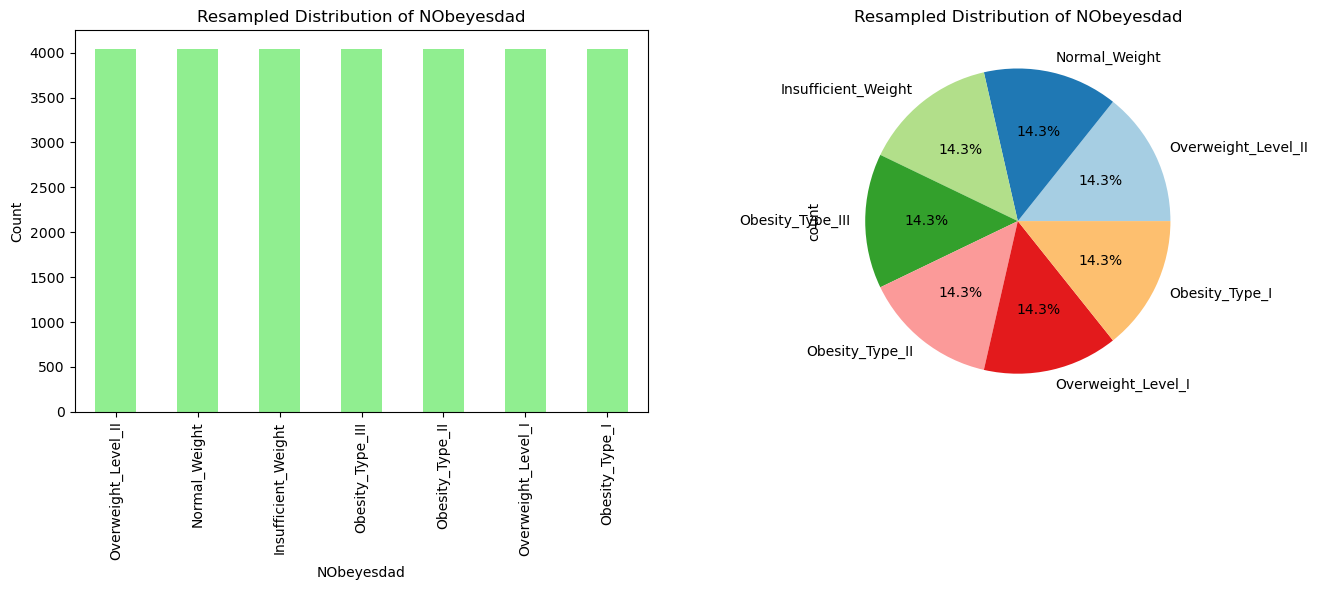

Evaluation Metrics for Decision Tree:
Training Time: 0.9612 seconds
Confusion Matrix:
[[269   3   0   0   0   0   0]
 [ 11 243   0   0   0  29   4]
 [  0   0 328  14   0   0   9]
 [  0   0   5 291   1   0   0]
 [  0   0   0   1 323   0   0]
 [  0  12   4   0   0 240  34]
 [  0   0  17   3   0  17 253]]


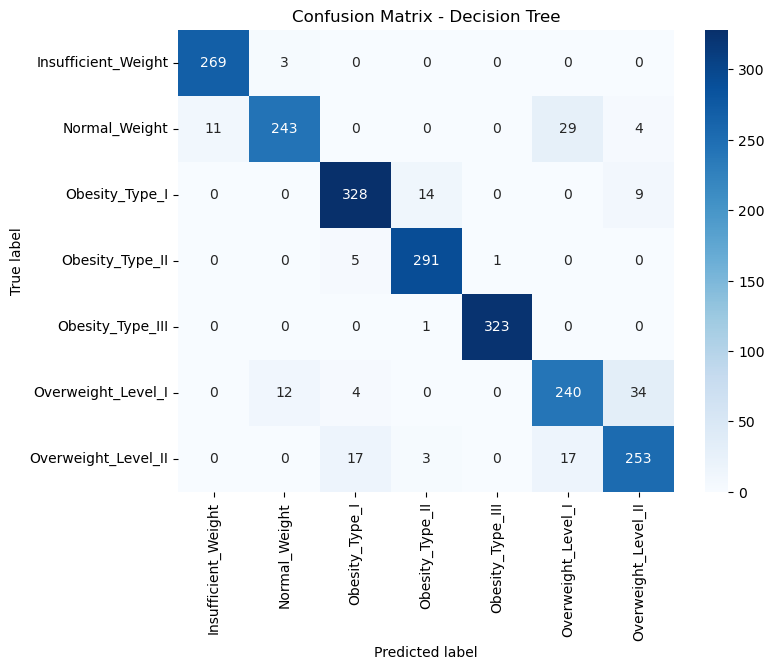

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.99      0.97       272
      Normal_Weight       0.94      0.85      0.89       287
     Obesity_Type_I       0.93      0.93      0.93       351
    Obesity_Type_II       0.94      0.98      0.96       297
   Obesity_Type_III       1.00      1.00      1.00       324
 Overweight_Level_I       0.84      0.83      0.83       290
Overweight_Level_II       0.84      0.87      0.86       290

           accuracy                           0.92      2111
          macro avg       0.92      0.92      0.92      2111
       weighted avg       0.92      0.92      0.92      2111

MCC Score: 0.9094


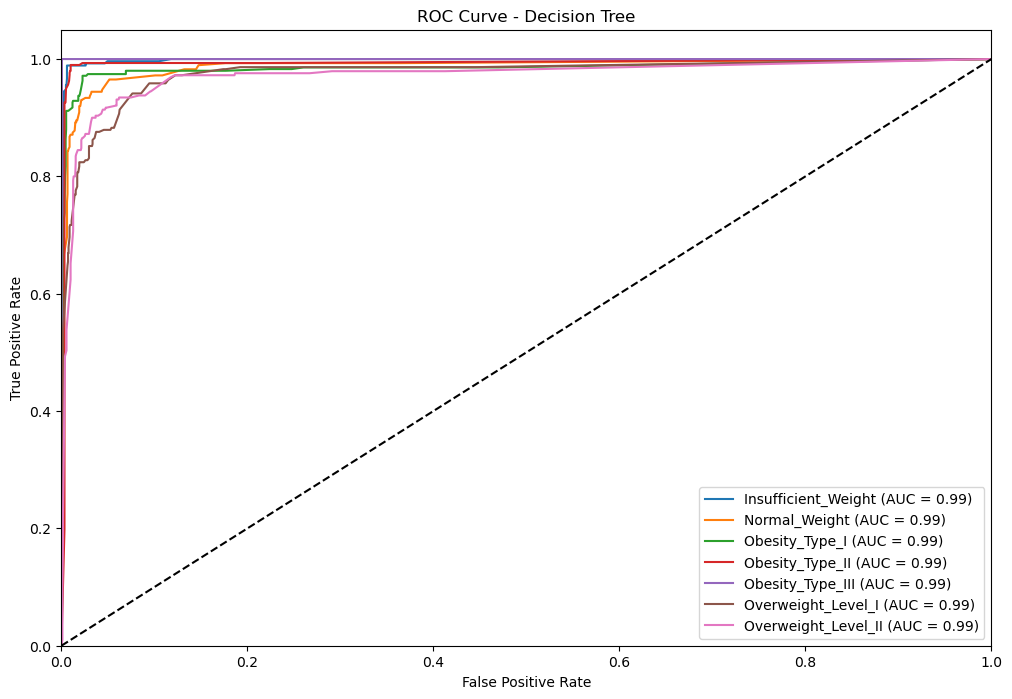

AUC Score: 0.9872
Evaluation Metrics for Logistic Regression:
Training Time: 3.7080 seconds
Confusion Matrix:
[[271   1   0   0   0   0   0]
 [ 28 227   0   0   0  32   0]
 [  0   0 321  19   0   0  11]
 [  0   0   4 293   0   0   0]
 [  0   0   1   1 322   0   0]
 [  0   3   0   0   0 255  32]
 [  0   0  26   0   0  18 246]]


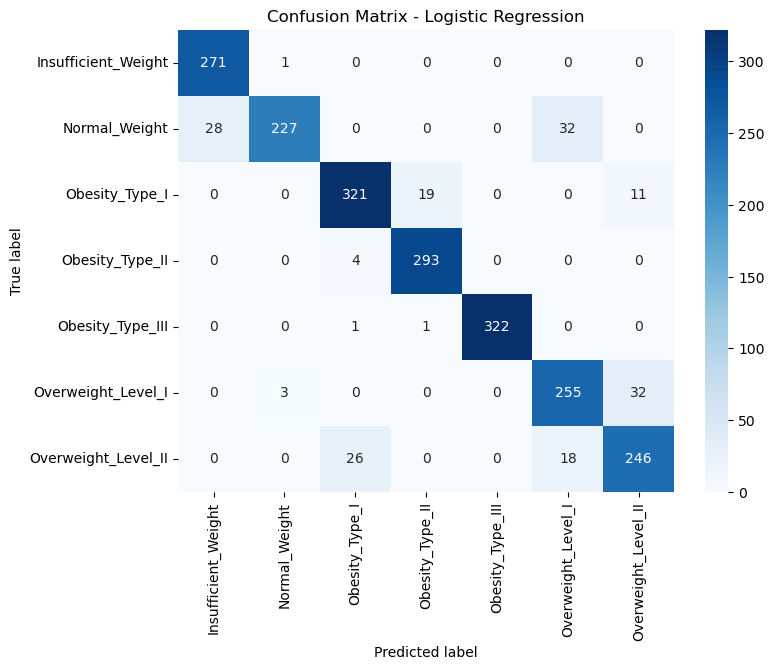

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      1.00      0.95       272
      Normal_Weight       0.98      0.79      0.88       287
     Obesity_Type_I       0.91      0.91      0.91       351
    Obesity_Type_II       0.94      0.99      0.96       297
   Obesity_Type_III       1.00      0.99      1.00       324
 Overweight_Level_I       0.84      0.88      0.86       290
Overweight_Level_II       0.85      0.85      0.85       290

           accuracy                           0.92      2111
          macro avg       0.92      0.92      0.91      2111
       weighted avg       0.92      0.92      0.92      2111

MCC Score: 0.9031


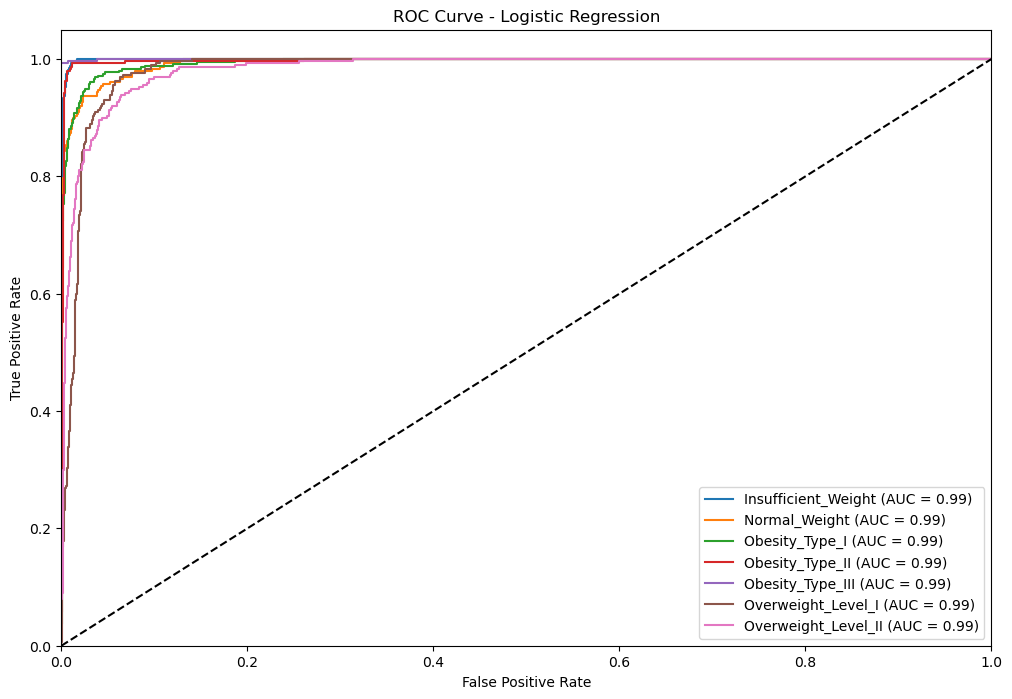

AUC Score: 0.9929
Evaluation Metrics for SVM:
Training Time: 96.0272 seconds
Confusion Matrix:
[[265   7   0   0   0   0   0]
 [ 13 232   0   0   0  39   3]
 [  0   0 321  19   0   0  11]
 [  0   0   1 295   0   0   1]
 [  0   0   1   1 322   0   0]
 [  1   7   2   0   0 256  24]
 [  0   0   6   3   0  11 270]]


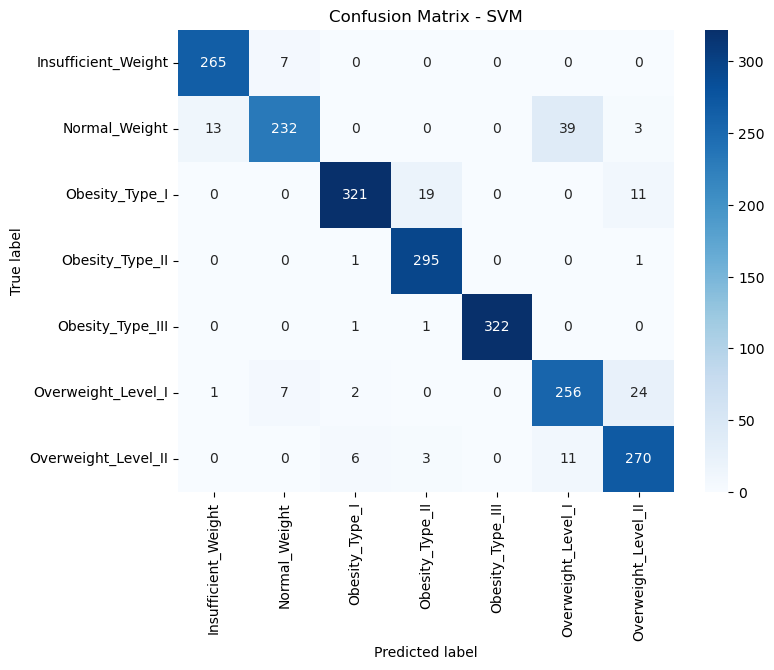

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.97      0.96       272
      Normal_Weight       0.94      0.81      0.87       287
     Obesity_Type_I       0.97      0.91      0.94       351
    Obesity_Type_II       0.93      0.99      0.96       297
   Obesity_Type_III       1.00      0.99      1.00       324
 Overweight_Level_I       0.84      0.88      0.86       290
Overweight_Level_II       0.87      0.93      0.90       290

           accuracy                           0.93      2111
          macro avg       0.93      0.93      0.93      2111
       weighted avg       0.93      0.93      0.93      2111

MCC Score: 0.9174


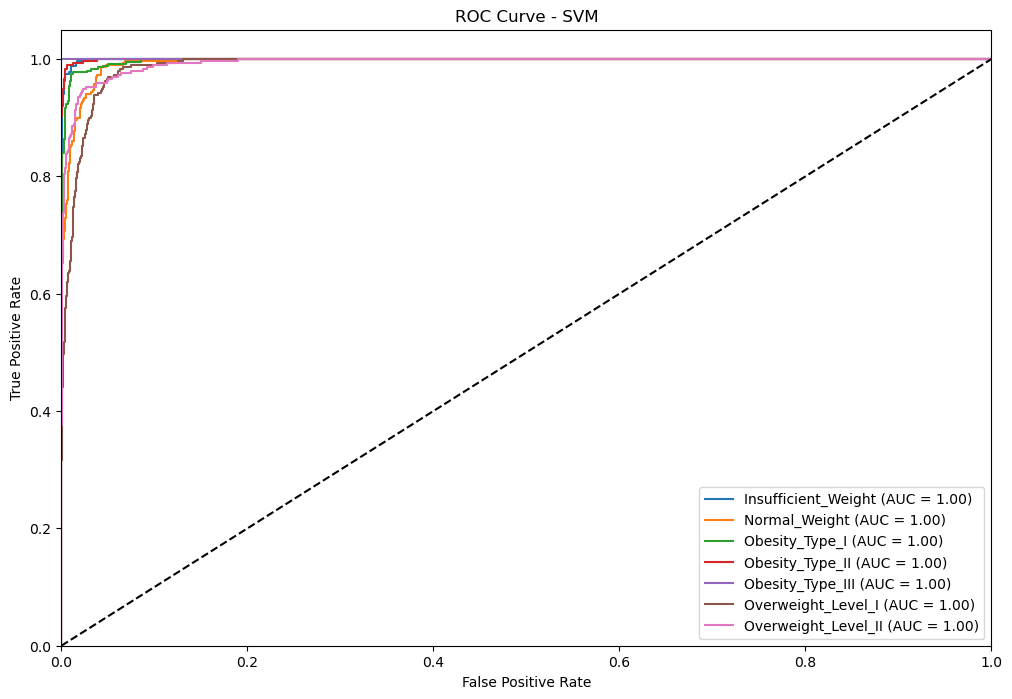

AUC Score: 0.9964
Evaluation Metrics for Random Forest:
Training Time: 18.5174 seconds
Confusion Matrix:
[[263   9   0   0   0   0   0]
 [  5 256   0   0   0  20   6]
 [  0   0 327  14   0   0  10]
 [  0   1   1 294   1   0   0]
 [  0   0   2   0 322   0   0]
 [  0  10   0   0   0 260  20]
 [  0   4   6   3   0  11 266]]


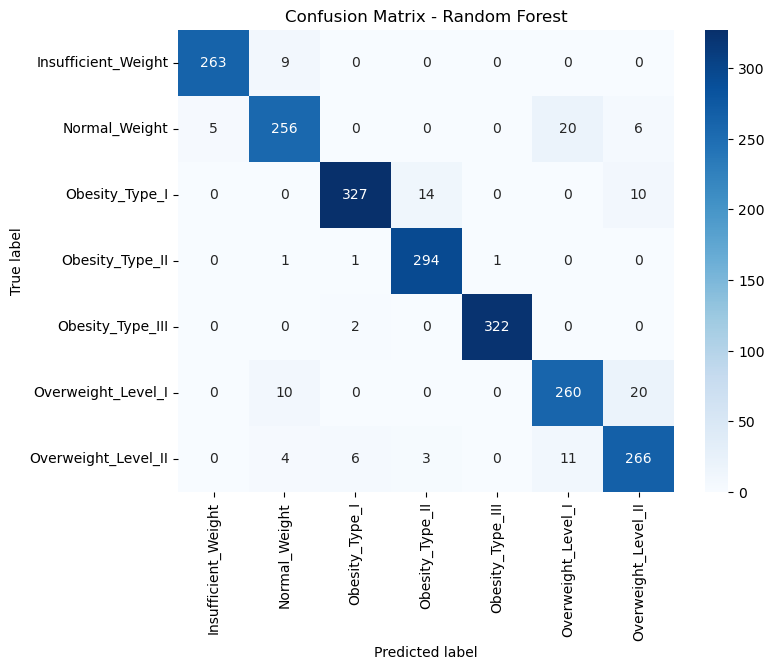

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.97      0.97       272
      Normal_Weight       0.91      0.89      0.90       287
     Obesity_Type_I       0.97      0.93      0.95       351
    Obesity_Type_II       0.95      0.99      0.97       297
   Obesity_Type_III       1.00      0.99      1.00       324
 Overweight_Level_I       0.89      0.90      0.90       290
Overweight_Level_II       0.88      0.92      0.90       290

           accuracy                           0.94      2111
          macro avg       0.94      0.94      0.94      2111
       weighted avg       0.94      0.94      0.94      2111

MCC Score: 0.9320


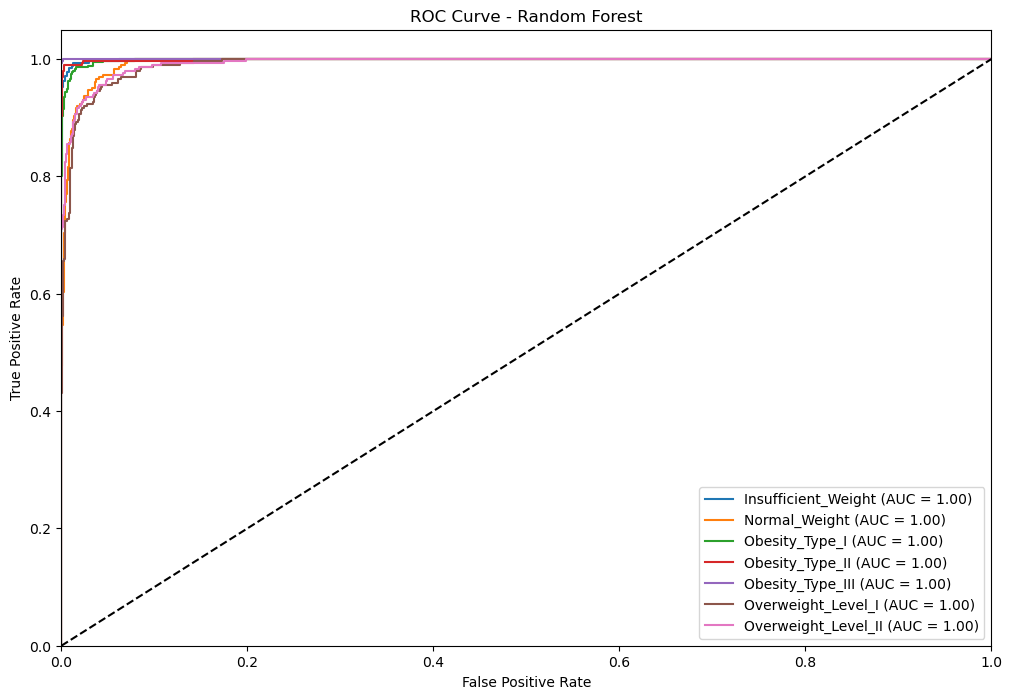

AUC Score: 0.9967
Evaluation Metrics for XGBoost:
Training Time: 3.9641 seconds
Confusion Matrix:
[[269   3   0   0   0   0   0]
 [  7 248   0   0   0  31   1]
 [  0   0 328  16   0   0   7]
 [  0   0   3 294   0   0   0]
 [  0   0   2   0 322   0   0]
 [  0   7   1   0   0 271  11]
 [  0   0  12   4   0  17 257]]


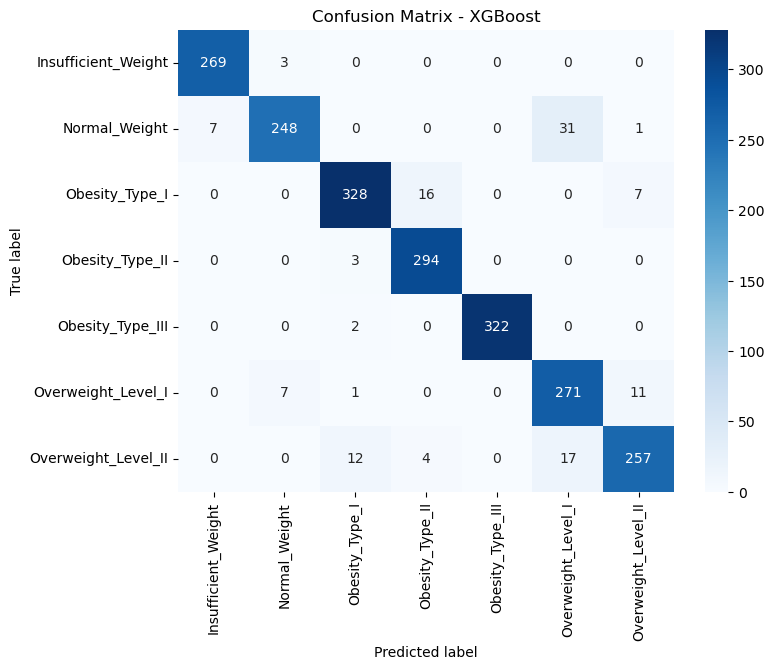

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.97      0.99      0.98       272
      Normal_Weight       0.96      0.86      0.91       287
     Obesity_Type_I       0.95      0.93      0.94       351
    Obesity_Type_II       0.94      0.99      0.96       297
   Obesity_Type_III       1.00      0.99      1.00       324
 Overweight_Level_I       0.85      0.93      0.89       290
Overweight_Level_II       0.93      0.89      0.91       290

           accuracy                           0.94      2111
          macro avg       0.94      0.94      0.94      2111
       weighted avg       0.94      0.94      0.94      2111

MCC Score: 0.9328


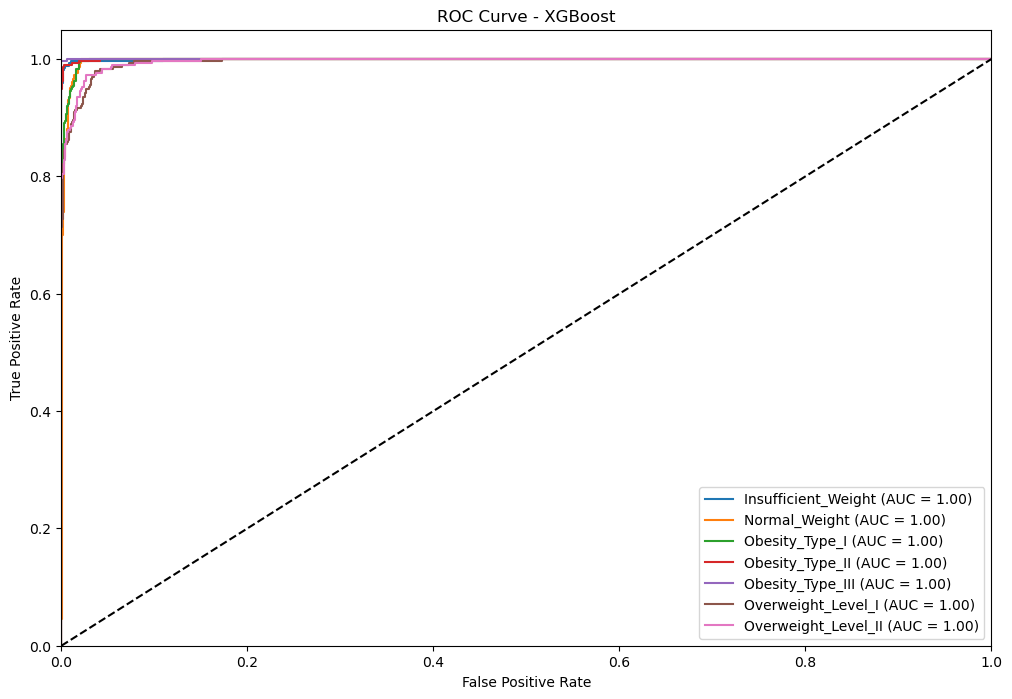

AUC Score: 0.9982


In [ ]:
# Initialize dictionaries to store evaluation metrics
confusion_matrices = {}
classification_reports = {}
roc_curves = {}
auc_scores = {}
training_times = {}
mcc_scores = {}
tp_fp_tn_fn = {}

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


for name, model in best_estimators.items():
    start_time = time.time()
    model.fit(X_train, y_train_encoded)
    training_time = time.time() - start_time
    
    y_test_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_test_pred_proba = model.predict_proba(X_test)
    else:
        y_test_pred_proba = None
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_test_pred)
    confusion_matrices[name] = cm
    
  
    
    # Classification Report
    report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_)
    classification_reports[name] = report
    
    # ROC Curve and AUC
    if y_test_pred_proba is not None:
        auc = roc_auc_score(y_test_encoded, y_test_pred_proba, multi_class='ovr')
        auc_scores[name] = auc
        roc_curves[name] = {}
        for i, class_name in enumerate(label_encoder.classes_):
            fpr, tpr, _ = roc_curve(y_test_encoded, y_test_pred_proba[:, i], pos_label=i)
            roc_curves[name][class_name] = (fpr, tpr)
    
    # MCC Score
    mcc = matthews_corrcoef(y_test_encoded, y_test_pred)
    mcc_scores[name] = mcc
    
    # Training Time
    training_times[name] = training_time

# Display evaluation metrics
for name in best_estimators.keys():
    print(f"Evaluation Metrics for {name}:")
    print(f"Training Time: {training_times[name]:.4f} seconds")
    print(f"Confusion Matrix:\n{confusion_matrices[name]}")
    plot_confusion_matrix(confusion_matrices[name], classes=label_encoder.classes_, title=f'Confusion Matrix - {name}')
    print(f"Classification Report:\n{classification_reports[name]}")
    print(f"MCC Score: {mcc_scores[name]:.4f}")
    
    
    if name in roc_curves:
        plt.figure(figsize=(12, 8))
        for class_name, (fpr, tpr) in roc_curves[name].items():
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_scores[name]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()
        print(f"AUC Score: {auc_scores[name]:.4f}")
    print("="*80)

# Stability Analysis
stability_scores = {name: [] for name in base_pipelines.keys()}
for seed in range(5):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for name, pipeline in base_pipelines.items():
        scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=kf, scoring='accuracy')
        stability_scores[name].append(np.mean(scores))

# Plot stability analysis
plt.figure(figsize=(12, 8))
for name, scores in stability_scores.items():
    plt.plot(range(5), scores, marker='o', label=name)

plt.title('Stability Analysis of Different Models')
plt.xlabel('Random Seed')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# AUC ROC for SVM